In [ ]:
from bert_score import score
from datasets import load_dataset, load_metric
from torch.utils.data import Dataset, random_split, DataLoader, \
                             RandomSampler, SequentialSampler

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer,AutoTokenizer, AutoConfig
import pandas as pd
import nltk
import numpy as np
from sklearn.model_selection import train_test_split
import random
import torch
metric = load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [ ]:
!rm -rf "/content/drive/MyDrive/t5-trial-inf-abstract"

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
! pip install datasets transformers rouge-score nltk bert_score

     |████████████████████████████████| 298 kB 13.0 MB/s 
     |████████████████████████████████| 3.3 MB 55.1 MB/s 
     |████████████████████████████████| 60 kB 7.7 MB/s 
     |████████████████████████████████| 1.1 MB 83.0 MB/s 
     |████████████████████████████████| 61 kB 609 kB/s 
     |████████████████████████████████| 243 kB 75.4 MB/s 
     |████████████████████████████████| 132 kB 78.3 MB/s 
     |████████████████████████████████| 895 kB 81.5 MB/s 
     |████████████████████████████████| 596 kB 76.2 MB/s 
     |████████████████████████████████| 3.3 MB 77.4 MB/s 
     |████████████████████████████████| 192 kB 82.0 MB/s 
     |████████████████████████████████| 160 kB 83.7 MB/s 
     |████████████████████████████████| 271 kB 90.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
from ast import literal_eval
df_nyt = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data/NYT_Dataset.csv",index_col=0,converters={'keywords': literal_eval})
df_nyt.dropna(inplace= True)  
# df_nyt = df_nyt.iloc[0:200]

[Text(0, 0, 'Foreign'), Text(0, 0, 'U.S.'), Text(0, 0, 'Politics')]

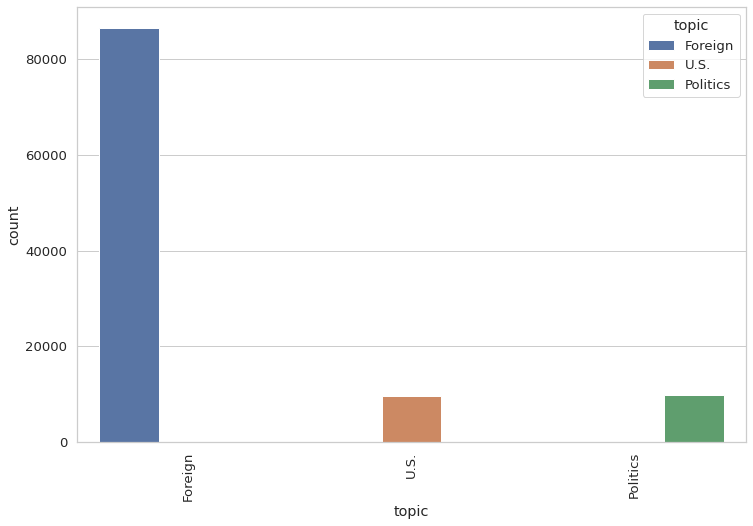

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (12,8))
sns.set(style = "whitegrid",font_scale = 1.2)
chart = sns.countplot(x = "topic", hue = "topic" , data = df_nyt)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

In [ ]:
def get_tokenier(special_tokens=None):
    tokenizer = AutoTokenizer.from_pretrained(MODEL) 

    if special_tokens:
        tokenizer.add_special_tokens(special_tokens)
        print("Special tokens added")
    return tokenizer

def get_model(tokenizer, special_tokens=None, load_model_path=None):


    if special_tokens:
        config = AutoConfig.from_pretrained(MODEL, 
                                            bos_token_id=tokenizer.bos_token_id,
                                            eos_token_id=tokenizer.eos_token_id,
                                            sep_token_id=tokenizer.sep_token_id,
                                            pad_token_id=tokenizer.pad_token_id,                                           
                                            output_hidden_states=False)
    else: 
        config = AutoConfig.from_pretrained(MODEL,                                     
                                            pad_token_id=tokenizer.eos_token_id,
                                            output_hidden_states=False)    

    #----------------------------------------------------------------#
    model = AutoModelForSeq2SeqLM.from_pretrained(MODEL, config=config)

    if special_tokens:
        #Special tokens added, model needs to be resized accordingly
        model.resize_token_embeddings(len(tokenizer))

    if load_model_path:
        model.load_state_dict(torch.load(load_model_path))

    model.cuda()
    return model

In [ ]:
#for conditional text generation
class prepareDataset(Dataset):

    def __init__(self, data, tokenizer, randomize=True):

        topic, abstract, keywords, title = [], [], [], []
        for i in range(len(data)):
            topic.append(data.iloc[0]["topic"])
            abstract.append(data.iloc[0]["abstract"])
            keywords.append(data.iloc[0]["keywords"])
            title.append(data.iloc[0]["title"])

        self.randomize = randomize
        self.tokenizer = tokenizer 
        self.title     = title
        self.topic     = topic
        self.text      = abstract
        self.keywords  = keywords 
         

    #---------------------------------------------#

    @staticmethod
    def join_keywords(keywords, randomize=True):
        N = len(keywords)

        #random sampling and shuffle
        if randomize: 
            M = random.choice(range(N+1))
            keywords = keywords[:M]
            random.shuffle(keywords)

        return ','.join(keywords)

    #---------------------------------------------#

    def __len__(self):
        return len(self.text)

    #---------------------------------------------#
    
    def __getitem__(self, i):
        keywords = self.keywords[i].copy()
        kw = self.join_keywords(keywords, self.randomize)
        input = "summarize: "+self.text[i]
        encodings_dict = tokenizer(input,                                   
                                   truncation=True, 
                                   max_length=512, 
                                   padding="max_length") 
        

        encodings_dict_1 = tokenizer(self.title[i],                                   
                            truncation=True, 
                            max_length=50, 
                            padding="max_length")   
        
        input_ids = encodings_dict['input_ids']
        label_ids = encodings_dict_1['input_ids']
        attention_mask = encodings_dict['attention_mask']
        
        return {'labels': torch.tensor(label_ids),
                'input_ids': torch.tensor(input_ids), 
                'attention_mask': torch.tensor(attention_mask)}

In [ ]:
MODEL = "t5-small"
model_name = "t5-small"
tokenizer = get_tokenier(special_tokens=None)
model = get_model(tokenizer, 
                  special_tokens=None
                  ,               #   load_model_path='pytorch_model.bin'
                 )

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/231M [00:00<?, ?B/s]

In [ ]:
# df_nyt = df_nyt.iloc[0:200]
train_data,val_data = train_test_split(df_nyt,test_size=0.2,random_state=0)

train_dataset = prepareDataset(train_data, tokenizer)
val_dataset = prepareDataset(val_data, tokenizer, randomize=False)

f'Total {len(train_dataset) :,} samples for training, and total {len(val_dataset) :,} samples for  testing'


'Total 84,738 samples for training, and total 21,185 samples for  testing'

In [ ]:
batch_size = 16

args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/MyDrive/t5-trial-inf-abstract",
    # evaluation_strategy = "steps",
    # save_strategy = "steps",
    evaluation_strategy = "epoch",
    run_name = 't5-wandb2',
    save_strategy = "epoch",    
    learning_rate=2e-5,
    # eval_steps=10,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=2,
    do_train=True,
    predict_with_generate=True,  
    load_best_model_at_end=True,  
    fp16=True,
    report_to="wandb",
)

In [ ]:
pip install wandb

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Using amp half precision backend


In [ ]:
trainer.train()

***** Running training *****
  Num examples = 84738
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 10594


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,0.000000,2.803313,19.354800,6.896600,12.903200,12.903200,19.000000
2,0.000000,2.803432,19.354800,6.896600,12.903200,12.903200,19.000000


***** Running Evaluation *****
  Num examples = 21185
  Batch size = 16


Epoch,Training Loss,Validation Loss


Saving model checkpoint to /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-5297
Configuration saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-5297/config.json
Model weights saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-5297/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-5297/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-5297/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 21185
  Batch size = 16
Saving model checkpoint to /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-10594
Configuration saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-10594/config.json
Model weights saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-10594/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/t5-trial-inf-abstract/checkpoint-10594/tokenizer_config.json
Special to

TrainOutput(global_step=10594, training_loss=1.591999210765923e-05, metrics={'train_runtime': 4813.3616, 'train_samples_per_second': 35.209, 'train_steps_per_second': 2.201, 'total_flos': 2.588101830102221e+16, 'train_loss': 1.591999210765923e-05, 'epoch': 2.0})

**EVALUATION**

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 21185
  Batch size = 16


Exception: ignored

In [ ]:
df_model_analysis = pd.read_csv("/content/drive/MyDrive/evaluation_file_model_wise_nlp.csv",sep = "|")

df_model_analysis

,model_name,Score-Algo,score
0,T5-small-base,BertScore,tensor(0.8483)
1,T5-small-base-finetuned-abstract,BertScore,tensor(0.8505)
2,T5-small-base-finetuned-abstract,Rouge1,9.3548
3,T5-small-base-finetuned-abstract,Rouge2,6.8966
4,T5-small-base-finetuned-abstract,Rougel,12.9032
5,T5-small-base-finetuned-abstract,BleurtScore,-0.9204243421554565


In [ ]:
def predict_title(article):    

    text =  "summarize: " + article

    max_len = 256

    encoding = tokenizer(text, return_tensors = "pt")
    input_ids = encoding["input_ids"].to(device)
    attention_masks = encoding["attention_mask"].to(device)

    beam_outputs = model.generate(
        input_ids = input_ids,
        attention_mask = attention_masks,
        max_length = 18,
        min_length = 8,
        num_beams = 3,
        early_stopping = True,
    )

    result = tokenizer.decode(beam_outputs[0])
    return(result)

In [ ]:
title_pred =[]
title_original = []
for i in range(len(val_data)):
    if(i%2000 == 0):
        print(i)
    title_pred.append(predict_title(val_data.iloc[i]["abstract"]))
    title_original.append(val_data.iloc[i]["title"])


In [ ]:
title_pred =title_pred[0:10000]
title_original = title_original[0:10000]
print(len(title_pred))
print(len(title_original))

In [ ]:
val_data1 = val_data.iloc[0:10000,]

In [ ]:
val_data1["title_pred"] = title_pred


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
val_data1.to_csv("/content/drive/MyDrive/example_data_t5_abstract.csv",sep = "|",index= False)

In [ ]:
def calculate_bert_score(predicted_title,true_title):
    P, R, F1 = score(predicted_title, true_title, lang='en')
    f1_score = F1.mean()
    print(f"System level F1 score: {F1.mean():.3f}")
    return f1_score

In [ ]:
val_data.head()

,ID,title,topic,abstract,Date,keywords
56326,nyt://article/4c4dfb4b-3805-545d-843e-fd1ebea0...,Bid by Omar al-Bashir of Sudan to Avoid Arrest...,Foreign,A South African court issued an interim order ...,2015-06-14 13:38:54+00:00,"[Bashir, Omar Hassan Al-, Onishi, Norimitsu, S..."
73151,nyt://article/c2493dc5-da9a-5d12-9262-8a6fad09...,"At Hong Kong New Year Fair, Defiance Gives Way...",Foreign,"Along with fish balls and flowers, vendors in ...",2017-01-27 10:09:00+00:00,"[Hong Kong, Lunar New Year, Politics and Gover..."
4447,nyt://article/ccf7a590-2414-5a2b-8256-e3064b99...,Talks Under Way to Free Europeans and Egyptians,Foreign,The kidnappers of 11 European tourists and 8 E...,2008-09-22 12:58:57+00:00,"[Kidnapping, International Relations, Hostages..."
79086,nyt://article/ddd01dea-4da4-55e1-9e87-9437700f...,Zimbabwe Releases American Charged With Insult...,Foreign,Martha O’Donovan was charged with undermining ...,2018-01-04 16:42:28+00:00,"[Zimbabwe, Social Media, O'Donovan, Martha (19..."
66543,nyt://article/fd2382f0-8b96-5083-ab07-77113ea9...,Wisconsin Poll Shows Ted Cruz Ahead of Donald ...,Politics,A new poll of likely Wisconsin voters on Wedne...,2016-03-30 19:43:27+00:00,"[Polls and Public Opinion, Presidential Electi..."


In [ ]:
import textwrap
for i in range(10):
    print("abstract:",textwrap.fill(val_data.iloc[i]["abstract"]))
    print("Original title:",textwrap.fill(val_data.iloc[i]["title"]))
    print("Predicted title:",predict_title(val_data.iloc[i]["abstract"]))
    print("\n")

abstract: A South African court issued an interim order to prevent the Sudanese
president from leaving the country after the International Criminal
Court sought his arrest on genocide charges.
Original title: Bid by Omar al-Bashir of Sudan to Avoid Arrest Is Tested in South
Africa
Predicted title: <pad> a court issued an interim order to prevent the president from leaving the country.


abstract: Along with fish balls and flowers, vendors in Victoria Park sold a
game with a predetermined set of outcomes, a nod to the Beijing-
directed selection of the city’s leader.
Original title: At Hong Kong New Year Fair, Defiance Gives Way to Resignation
Predicted title: <pad> vendors in Victoria Park sold a game with a predetermined set of outcomes 


abstract: The kidnappers of 11 European tourists and 8 Egyptians who were taken
have demanded $6 million to free them, a government official said.
Original title: Talks Under Way to Free Europeans and Egyptians
Predicted title: <pad> 11 european tou

test1 = val_data.iloc[0:50,]
test1.to_csv("/content/drive/MyDrive/example_data_t5_.csv",sep = "|",index= False)

import wandb
wandb.finish()

In [ ]:
df_model_analysis

In [ ]:
accuracy_score = calculate_bert_score(title_pred,title_original)
print(accuracy_score)
# df_model_analysis.to_csv("/content/drive/MyDrive/evaluation_file_model_wise_nlp.csv",sep = "|",index= False)
df_model_analysis.loc[len(df_model_analysis)] = ["T5-small-base-finetuned-abstract","BertScore",accuracy_score]
df_model_analysis

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/roberta-large/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/dea67b44b38d504f2523f3ddb6acb601b23d67bee52c942da336fa1283100990.94cae8b3a8dbab1d59b9d4827f7ce79e73124efa6bb970412cd503383a95f373
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.13.0",
  "type_vocab_size": 1,
  "use_c

System level F1 score: 0.851
tensor(0.8505)


,model_name,Score-Algo,score
0,T5-small-base,BertScore,tensor(0.8483)
1,T5-small-base-finetuned-abstract,BertScore,tensor(0.8505)


# **Bleurt Score**

In [ ]:
!pip install --upgrade pip
!git clone https://github.com/google-research/bleurt.git
%cd bleurt
!pip install .

In [ ]:
!python -m unittest bleurt.score_test
!python -m unittest bleurt.score_not_eager_test
!python -m unittest bleurt.finetune_test
!python -m unittest bleurt.score_files_test

In [ ]:
from bleurt import score
import statistics
def calculate_bleurt_score(predicted_title,true_title):
    checkpoint = "bleurt/test_checkpoint"
    scorer = score.BleurtScorer(checkpoint)
    scores = scorer.score(references=true_title,candidates=predicted_title)
    return statistics.median(scores)

In [ ]:
accuracy_score = calculate_bleurt_score(title_pred,title_original)
print(accuracy_score)
# df_model_analysis.to_csv("/content/drive/MyDrive/evaluation_file_model_wise_nlp.csv",sep = "|",index= False)
df_model_analysis.loc[len(df_model_analysis)] = ["T5-small-base-finetuned-abstract","BleurtScore",accuracy_score]
df_model_analysis

INFO:tensorflow:Reading checkpoint bleurt/test_checkpoint.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint dbleurt_tiny
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:dbleurt_tiny
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.
INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.
-0.9204243421554565


,model_name,Score-Algo,score
0,T5-small-base,BertScore,tensor(0.8483)
1,T5-small-base-finetuned-abstract,BertScore,tensor(0.8505)
2,T5-small-base-finetuned-abstract,Rouge1,9.3548
3,T5-small-base-finetuned-abstract,Rouge2,6.8966
4,T5-small-base-finetuned-abstract,Rougel,12.9032
5,T5-small-base-finetuned-abstract,BleurtScore,-0.920424



**ROUGE SCORE**

In [ ]:
from rouge_score import rouge_scorer
import statistics
F1_rouge1 = []
F1_rouge2 = []
F1_rouge_L = []
def calculate_rouge_score(predicted_title,true_title):
    scorer = rouge_scorer.RougeScorer(['rouge1','rouge2','rougeL'], use_stemmer=True)
    for (orig, pred) in zip(predicted_title, true_title):
        scores = scorer.score(str.lower(orig),str.lower(pred))
        F1_rouge1.append(scores['rouge1'][2])
        F1_rouge2.append(scores['rouge2'][2])
        F1_rouge_L.append(scores['rougeL'][2])
    return statistics.median(F1_rouge1),statistics.median(F1_rouge2),statistics.median(F1_rouge_L)

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
for (orig, pred) in zip(original, predicted):
  scores = scorer.score(str.lower(orig),str.lower(pred))
  precision_R1.append(scores['rouge1'][0])
  recall_R1.append(scores['rouge1'][1])
  f1_R1.append(scores['rouge1'][2])

  precision_RL.append(scores['rougeL'][0])
  recall_RL.append(scores['rougeL'][1])
  f1_RL.append(scores['rougeL'][2])

In [ ]:
calculate_rouge_score(title_pred,title_original)

(0.14814814814814814, 0.0, 0.1142857142857143)

In [ ]:
df_model_analysis = df_model_analysis.loc[df_model_analysis["Score-Algo"]!="Rouge2"]
df_model_analysis.loc[len(df_model_analysis)] = ["T5-small-base-finetuned-abstract","F1_rouge1",0.148]
df_model_analysis.loc[len(df_model_analysis)] = ["T5-small-base-finetuned-abstract","F1_rouge_L",0.11]

In [ ]:
df_model_analysis.to_csv("/content/drive/MyDrive/evaluation_file_model_wise_nlp.csv",sep = "|",index= False)

In [ ]:
df_model_analysis

,model_name,Score-Algo,score
0,T5-small-base,BertScore,tensor(0.8483)
1,T5-small-base-finetuned-abstract,BertScore,tensor(0.8505)
5,T5-small-base-finetuned-abstract,BleurtScore,-0.9204243421554565
3,T5-small-base-finetuned-abstract,F1_rouge1,0.148
4,T5-small-base-finetuned-abstract,F1_rouge_L,0.11
